# 核方法

核方法往简单地说，就是将一个低维的线性不可分的数据映射到一个高维的空间、并期望映射后的数据在高维空间里是线性可分的。我们以异或数据集为例：在二维空间中、异或数据集是线性不可分的；但是通过将其映射到三维空间、我们可以非常简单地让其在三维空间中变得线性可分。比如定义映射：

$$
\phi(x,y)=\left\{
\begin{aligned}
&(x,y,1),\ \ xy>0 \\
&(x,y,0),\ \ xy\le0
\end{aligned}
\right.
$$

该映射的效果如下图所示：

![核方法](https://ooo.0o0.ooo/2017/06/14/594109ab07368.png)

可以看到，虽然左图的数据集线性不可分、但显然右图的数据集是线性可分的，这就是核方法工作原理的一个不太严谨但仍然合理的解释

应用核方法的思路如下：
+ 将算法表述成样本点内积的组合（这经常能通过算法的对偶形式实现）
+ 设法找到核函数$K(xi,xj)$，它能返回样本点$x_i$、$x_j$被$\phi$作用后的内积
+ 用$K(xi,xj)$替换$xi\cdot xj$、完成低维到高维的映射（同时也完成了从线性算法到非线性算法的转换）

## 核感知机

感知机的原始损失函数为

$$
L(D) = \sum_{i=1}^N\left[ -y_i(w\cdot x_i+b)\right]_+
$$

为让损失函数中只含样本的内积，考虑令

$$
w = \sum_{i=1}^N\alpha_ix_i
$$

则

$$
\begin{align}
L(D) &= \sum_{i=1}^N\left[ -y_i\left[\left(\sum_{j=1}^N\alpha_jx_j\right)\cdot x_i+b\right]\right]_+ \\
&= \sum_{i=1}^N\left[ -y_i\left(\sum_{j=1}^N\alpha_j(x_i\cdot x_j)+b\right)\right]_+
\end{align}
$$

在此之上应用核方法是平凡的：设核函数为$K$，只需把所有的$x_i\cdot x_j$换成$K(x_i,x_j)$即可：

$$
L(D) = \sum_{i=1}^N\left[ -y_i\left(\sum_{j=1}^N\alpha_jK(x_i, x_j)+b\right)\right]_+
$$

于是优化问题变为

$$
\min_{\alpha}\sum_{i=1}^N\left[ -y_i\left(\sum_{j=1}^N\alpha_jK(x_i, x_j)+b\right)\right]_+
$$

易知，我们仍然可以用梯度下降法来求解该问题

In [1]:
import numpy as np

class KP:
    def __init__(self):
        self._x = None
        self._alpha = self._b = self._kernel = None
    
    # 定义多项式核函数
    @staticmethod
    def _poly(x, y, p=4):
        return (x.dot(y.T) + 1) ** p
    
    # 定义 rbf 核函数
    @staticmethod
    def _rbf(x, y, gamma):
        return np.exp(-gamma * np.sum((x[..., None, :] - y) ** 2, axis=2))
        
    def fit(self, x, y, kernel="poly", p=None, gamma=None, lr=0.001, batch_size=128, epoch=10000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        if kernel == "poly":
            p = 4 if p is None else p
            self._kernel = lambda x_, y_: self._poly(x_, y_, p)
        elif kernel == "rbf":
            gamma = 1 / x.shape[1] if gamma is None else gamma
            self._kernel = lambda x_, y_: self._rbf(x_, y_, gamma)
        else:
            raise NotImplementedError("Kernel '{}' has not defined".format(kernel))
        self._alpha = np.zeros(len(x))
        self._b = 0.
        self._x = x
        k_mat = self._kernel(x, x)
        for _ in range(epoch):
            indices = np.random.permutation(len(y))[:batch_size]
            k_mat_batch, y_batch = k_mat[indices], y[indices]
            err = -y_batch * (k_mat_batch.dot(self._alpha) + self._b)
            if np.max(err) < 0:
                continue
            mask = err >= 0
            delta = lr * y_batch[mask]
            self._alpha += np.sum(delta[..., None] * k_mat_batch[mask], axis=0)
            self._b += np.sum(delta)
    
    def predict(self, x, raw=False):
        x = np.atleast_2d(x).astype(np.float32)
        k_mat = self._kernel(self._x, x)
        y_pred = self._alpha.dot(k_mat) + self._b
        if raw:
            return y_pred
        return np.sign(y_pred).astype(np.float32)

### 进行简单的测试

准确率：   100.0 %


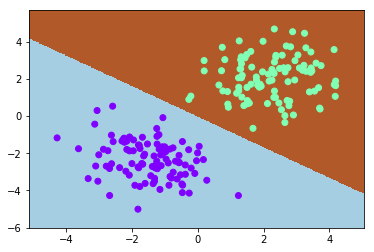

In [2]:
from Util import gen_two_clusters, visualize2d

xc, yc = gen_two_clusters()
kp = KP()
kp.fit(xc, yc, p=1)
print("准确率：{:8.6} %".format((kp.predict(xc) == yc).mean() * 100))
visualize2d(kp, xc, yc, True)

### 在非线性数据集上进行测试

准确率：    90.5 %


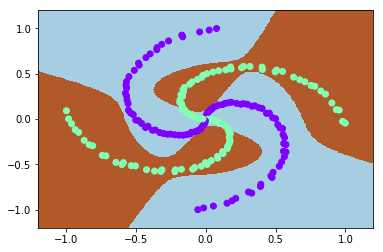

In [3]:
from Util import gen_spiral

xs, ys = gen_spiral()
kp = KP()
kp.fit(xs, ys, p=8)
print("准确率：{:8.6} %".format((kp.predict(xs) == ys).mean() * 100))
visualize2d(kp, xs, ys, True)

## 核 SVM

用同样的手法不难得出 LinearSVM 的核形式：

$$
L(D)=\frac12\sum_{i=1}^N\sum_{j=1}^N\alpha_i\alpha_jK(x_i,x_j)+C\sum_{i=1}^N\left[ 1-y_i\left(\sum_{j=1}^N\alpha_jK(x_i, x_j)+b\right)\right]_+
$$

可知求导仍然并不困难

In [4]:
class SVM(KP):        
    def fit(self, x, y, kernel="rbf", p=None, gamma=None, c=1, lr=0.0001, batch_size=128, epoch=10000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        if kernel == "poly":
            p = 4 if p is None else p
            self._kernel = lambda x_, y_: self._poly(x_, y_, p)
        elif kernel == "rbf":
            gamma = 1 / x.shape[1] if gamma is None else gamma
            self._kernel = lambda x_, y_: self._rbf(x_, y_, gamma)
        else:
            raise NotImplementedError("Kernel '{}' has not defined".format(kernel))
        self._alpha = np.zeros(len(x))
        self._b = 0.
        self._x = x
        k_mat = self._kernel(x, x)
        k_mat_diag = np.diag(k_mat)
        for _ in range(epoch):
            self._alpha -= lr * (np.sum(self._alpha * k_mat, axis=1) + self._alpha * k_mat_diag) * 0.5
            indices = np.random.permutation(len(y))[:batch_size]
            k_mat_batch, y_batch = k_mat[indices], y[indices]
            err = 1 - y_batch * (k_mat_batch.dot(self._alpha) + self._b)
            if np.max(err) <= 0:
                continue
            mask = err > 0
            delta = c * lr * y_batch[mask]
            self._alpha += np.sum(delta[..., None] * k_mat_batch[mask], axis=0)
            self._b += np.sum(delta)

### 进行简单的测试

准确率：   100.0 %


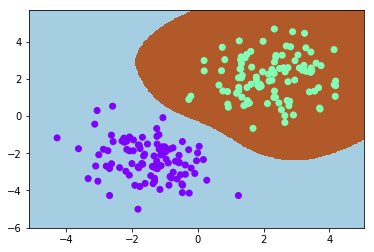

In [5]:
svm = SVM()
svm.fit(xc, yc)
print("准确率：{:8.6} %".format((svm.predict(xc) == yc).mean() * 100))
visualize2d(svm, xc, yc, True)

### 在非线性数据集上进行测试

准确率：    59.5 %


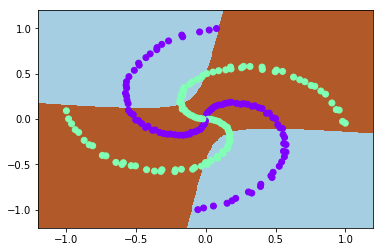

In [6]:
svm = SVM()
svm.fit(xs, ys)
print("准确率：{:8.6} %".format((svm.predict(xs) == ys).mean() * 100))
visualize2d(svm, xs, ys, True)

### 和 sklearn 的 SVM 进行比较

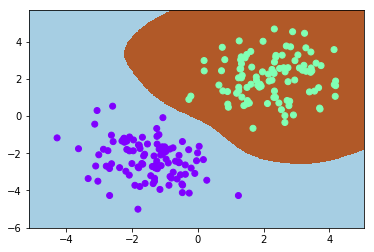

准确率：   100.0 %


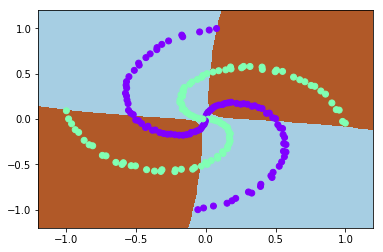

准确率：    54.5 %


In [7]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(xc, yc)
visualize2d(svm, xc, yc, True)
print("准确率：{:8.6} %".format((svm.predict(xc) == yc).mean() * 100))
svm.fit(xs, ys)
visualize2d(svm, xs, ys, True)
print("准确率：{:8.6} %".format((svm.predict(xs) == ys).mean() * 100))

孰优孰劣的话有点见仁见智的感觉。当然了，这只是两个非常简单的数据集，在真实数据集上，`sklearn`的`SVM`会比我们实现的`SVM`要好很多